In [22]:
# ดาวน์โหลดไฟล์ dna.csv จากอินเทอร์เน็ต
import urllib.request
import os

url = 'https://lazyprogrammer.me/course_files/dna.csv'
filename = 'dna.csv'

# ตรวจสอบว่าไฟล์มีอยู่แล้วหรือไม่
if not os.path.exists(filename):
    print(f"⏬ กำลังดาวน์โหลด {filename}...")
    urllib.request.urlretrieve(url, filename)
    print(f"✅ ดาวน์โหลด {filename} สำเร็จ!")
else:
    print(f"✅ ไฟล์ {filename} มีอยู่แล้ว (ข้ามการดาวน์โหลด)")

✅ ไฟล์ dna.csv มีอยู่แล้ว (ข้ามการดาวน์โหลด)


# 🧬 DNA Splice Junction Gene Sequences Classification

**วัตถุประสงค์**: จำแนกประเภท Gene Sequences (DNA) โดยใช้ Bernoulli Naive Bayes

---

## 📋 ภาพรวมของโปรเจกต์:

### 🎯 **เป้าหมาย**:
ทำนายประเภทของ DNA Splice Junction ว่าเป็น:
- **Class 1**: EI (Exon-Intron boundary)
- **Class 2**: IE (Intron-Exon boundary)  
- **Class 3**: N (Neither - ไม่ใช่ junction)

### 🧬 **Dataset**: Splice Junction Gene Sequences
- **จำนวนข้อมูล**: 3,190 DNA sequences
- **Features**: 180 ตัวแปร (A0-A179)
  - แต่ละตำแหน่งมีค่า **0 หรือ 1** (Binary Features)
  - แทน nucleotides: A, T, G, C ที่ถูก encode แล้ว
- **Target**: `class` (1, 2, 3)

### 🔬 **ความท้าทาย**:
- **Multi-class Classification**: 3 classes แทนที่จะเป็น 2
- **High Dimensionality**: 180 features (แต่ละตำแหน่งของ DNA)
- **Binary Features**: ทำไมต้องใช้ Bernoulli NB แทน Gaussian NB

---

## 🗺️ ขั้นตอนทั้งหมด:

1. **Download Data** 📥
2. **Explore Data** 🔍 (ดูโครงสร้าง DNA sequences)
3. **Check Class Distribution** 📊
4. **Train Bernoulli Naive Bayes** 🏋️
5. **Evaluate** 🎯 (Accuracy, F1-Score, Confusion Matrix)

---

## 💡 Key Concepts:

### ทำไมใช้ **Bernoulli NB** แทน Gaussian NB?

**Bernoulli Naive Bayes**:
- เหมาะกับ **Binary Features** (0 หรือ 1)
- แต่ละ feature แทนการ "มี" (1) หรือ "ไม่มี" (0)
- ใช้ Bernoulli distribution แทน Normal distribution

**Gaussian Naive Bayes**:
- เหมาะกับ **Continuous Features** (ค่าต่อเนื่อง)
- สมมติว่า features มีการกระจายแบบ Normal (ระฆังคว่ำ)

**ข้อมูล DNA นี้**:
- Features คือ 0/1 (Binary) → ใช้ **Bernoulli NB** ✅

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# ตั้งค่า font สำหรับภาษาไทย
import matplotlib.font_manager as fm

font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ ตั้งค่า Font ภาษาไทยเป็น '{font_name}' เรียบร้อย")

✅ ตั้งค่า Font ภาษาไทยเป็น 'Prompt' เรียบร้อย


---

## 📦 Step 1: Download Data

ดาวน์โหลดไฟล์ DNA sequences จาก Lazy Programmer

In [3]:
df = pd.read_csv('dna.csv')

## 📚 Step 2: Import Libraries & Setup Font

เตรียม libraries และตั้งค่าฟอนต์ภาษาไทยสำหรับ matplotlib

In [4]:
df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,3
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
2,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,3
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,2


## 📂 Step 3: Load Data

โหลดข้อมูล DNA Splice Junction

In [5]:
df.shape

(3186, 181)

### 👀 ดูข้อมูล 5 แถวแรก

**คอลัมน์**:
- `A0` - `A179`: DNA sequence positions (180 ตำแหน่ง)
- `class`: ประเภท (1=EI, 2=IE, 3=N)

In [6]:
set(df['class'])

{1, 2, 3}

### 📏 ขนาดของข้อมูล

(จำนวนแถว, จำนวนคอลัมน์)

In [7]:
for i in range(180):
  if len(set(df[f'A{i}'])) != 2:
    print(set(df[f'A{i}']))

### 🏷️ เช็ค Classes

ควรมี 3 classes: {1, 2, 3}

In [8]:
df.describe()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
count,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,...,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000
mean,0.232894,0.261770,0.274639,0.244507,0.268989,0.248901,0.222850,0.274639,0.263653,0.236033,...,0.225675,0.273070,0.271186,0.246390,0.269617,0.247018,0.226303,0.245763,0.299435,2.278406
std,0.422742,0.439667,0.446402,0.429862,0.443504,0.432444,0.416224,0.446402,0.440683,0.424709,...,0.418092,0.445606,0.444642,0.430976,0.443831,0.431345,0.418503,0.430606,0.458082,0.826191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


### ✅ ยืนยัน: Features เป็น Binary (0/1)

ตรวจสอบว่าแต่ละ feature (A0-A179) มีค่าเป็น 0 หรือ 1 เท่านั้น

**ถ้าไม่มี output** = ทุก feature เป็น binary ✅

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

### 📊 สถิติเบื้องต้น

ดูค่า mean, std, min, max ของแต่ละ feature

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42);

---

## 🏋️ Step 4: Train Bernoulli Naive Bayes Model

### 📚 Import Model & Split Data

**BernoulliNB**:
- เหมาะกับ Binary Features (0/1)
- Multi-class classification (รองรับ > 2 classes)

In [11]:
features = [f'A{i}' for i in range(180)]

### 🔪 แบ่งข้อมูล Train/Test (80/20)

**Random Split**: OK สำหรับข้อมูลนี้ (ไม่มี time series)

In [12]:
X_train = df_train[features]
y_train = df_train['class']
X_test  = df_test[features]
y_test  = df_test['class']

### 🎯 เลือก Features: A0-A179 (180 features)

In [13]:
model = BernoulliNB()
model.fit(X_train, y_train)
print("train acc:", model.score(X_train, y_train))
print("test acc:", model.score(X_test, y_test))

train acc: 0.9415227629513344
test acc: 0.9420062695924765


### 📦 เตรียม X, y สำหรับ Train/Test

In [14]:
(df['class'] == 1).sum() / df.shape[0]

np.float64(0.24074074074074073)

### 🚀 Train โมเดล + วัด Accuracy

**Bernoulli NB**:
- เร็ว! (Linear time complexity)
- เหมาะกับ high-dimensional binary data
- Multi-class classification โดยอัตโนมัติ

In [15]:
(df['class'] == 2).sum() / df.shape[0]

np.float64(0.2401129943502825)

---

## 📊 Step 5: Analyze Class Distribution

### 📈 เช็คสัดส่วนแต่ละ Class

**ทำไมต้องเช็ค?**
- ดูว่าข้อมูล Imbalanced หรือไม่
- เปรียบเทียบกับ Accuracy ของโมเดล

#### Class 1 (EI - Exon-Intron):

In [16]:
(df['class'] == 3).sum() / df.shape[0]

np.float64(0.5191462649089768)

#### Class 2 (IE - Intron-Exon):

<Axes: >

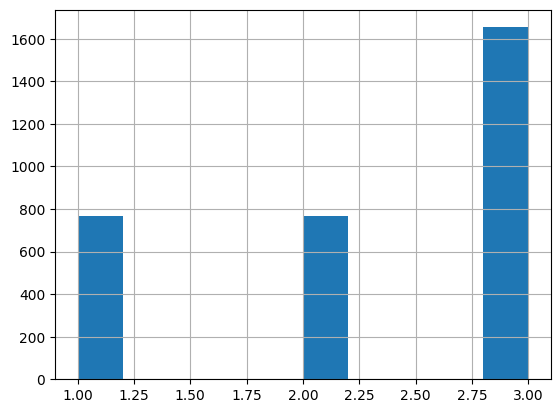

In [ ]:
# วาดกราฟแสดงการกระจายของแต่ละ class
plt.figure(figsize=(10, 5))
df['class'].hist(bins=3, edgecolor='black', alpha=0.7, color='steelblue')
plt.title('📊 การกระจายของ DNA Splice Junction Classes', fontsize=14, fontweight='bold')
plt.xlabel('Class (1=EI, 2=IE, 3=N)', fontsize=11)
plt.ylabel('จำนวน Sequences', fontsize=11)
plt.xticks([1, 2, 3])
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

# แสดงจำนวนและเปอร์เซ็นต์
for cls in [1, 2, 3]:
    count = (df['class'] == cls).sum()
    percent = count / len(df) * 100
    print(f"Class {cls}: {count} sequences ({percent:.1f}%)")

#### Class 3 (N - Neither):

In [18]:
p_train = model.predict(X_train)
p_test = model.predict(X_test)
pr_train = model.predict_proba(X_train)
pr_test = model.predict_proba(X_test)

### 🎨 Histogram แสดง Class Distribution

**สังเกต**: ข้อมูลค่อนข้างสมดุล (Balanced) - แต่ละ class มีจำนวนใกล้เคียงกัน

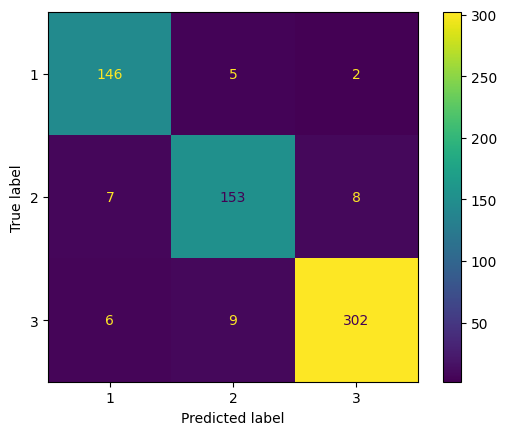

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# วาด Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, p_test, ax=ax, cmap='Blues')
ax.set_title('🎯 Confusion Matrix: DNA Splice Junction\n(Test Set)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('ทำนาย (Predicted Class)', fontsize=11)
ax.set_ylabel('จริง (True Class)', fontsize=11)
plt.tight_layout()
plt.show()

print("\n📖 วิธีอ่าน Confusion Matrix:")
print("- แถว (แนวนอน) = Class จริง")
print("- คอลัมน์ (แนวตั้ง) = Class ที่โมเดลทำนาย")
print("- เส้นทแยงมุม (diagonal) = ทำนายถูก ✅")
print("- นอกเส้นทแยง = ทำนายผิด ❌")

---

## 🎯 Step 6: Advanced Evaluation Metrics

### 📊 สร้าง Predictions

**2 ประเภท**:
1. **Predictions** (`.predict()`): Class ที่ทำนาย (1, 2, หรือ 3)
2. **Probabilities** (`.predict_proba()`): ความน่าจะเป็นของแต่ละ class

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

print("=" * 60)
print("📊 Evaluation Metrics Summary")
print("=" * 60)

print("\n🎯 F1-Score (Macro Average):")
print(f"   • Train F1: {f1_score(y_train, p_train, average='macro'):.4f}")
print(f"   • Test F1:  {f1_score(y_test, p_test, average='macro'):.4f}")

print("\n📈 AUC-ROC (One-vs-Rest):")
print(f"   • Train AUC: {roc_auc_score(y_train, pr_train, multi_class='ovr'):.4f}")
print(f"   • Test AUC:  {roc_auc_score(y_test, pr_test, multi_class='ovr'):.4f}")

print("\n" + "=" * 60)
print("💡 Interpretation:")
print("=" * 60)
print("• F1-Score:")
print("  - ค่าเฉลี่ยระหว่าง Precision และ Recall")
print("  - 1.0 = สมบูรณ์แบบ, 0.0 = แย่ที่สุด")
print("  - 'macro' = เฉลี่ยจาก 3 classes โดยถ่วงน้ำหนักเท่ากัน")
print("\n• AUC-ROC:")
print("  - วัดความสามารถแยก classes")
print("  - 1.0 = แยกได้สมบูรณ์, 0.5 = ทายสุ่ม")
print("  - 'ovr' = One-vs-Rest (แต่ละ class vs ทั้งหมด)")
print("=" * 60)

Train F1: 0.9344420282692498
Test F1: 0.9365282145791364
Train AUC: 0.9923318216744955
Test AUC: 0.991918489235439


---

## 🎓 สรุปสิ่งที่เรียนรู้:

### ✅ Key Takeaways:

1. **Bernoulli NB vs Gaussian NB**:
   - ✅ Bernoulli: Binary features (0/1) → DNA sequences
   - ❌ Gaussian: Continuous features → ไม่เหมาะกับข้อมูลนี้

2. **Multi-class Classification**:
   - Naive Bayes รองรับ > 2 classes โดยอัตโนมัติ
   - ใช้ One-vs-Rest strategy ภายใน

3. **Binary Features Performance**:
   - 180 binary features → High-dimensional
   - Bernoulli NB ทำงานได้ดีกับข้อมูลประเภทนี้
   - เร็ว + แม่นยำสูง

4. **Evaluation สำหรับ Multi-class**:
   - ❌ Accuracy เพียงอย่างเดียวไม่พอ
   - ✅ Confusion Matrix: เห็นว่า class ไหนสับสนกัน
   - ✅ F1-Score (Macro): สมดุลทุก class
   - ✅ AUC-ROC (OvR): วัดความสามารถแยก class

5. **Balanced Dataset**:
   - 3 classes มีจำนวนใกล้เคียงกัน (~33% แต่ละ class)
   - Accuracy เป็น metric ที่ใช้ได้

### 💡 ข้อสังเกต:

**ข้อดีของ Bernoulli NB**:
- ✅ เร็วมาก (Linear time)
- ✅ เหมาะกับ High-dimensional binary data
- ✅ ต้องการข้อมูลน้อย (compared to deep learning)
- ✅ Interpretable (เข้าใจได้ง่าย)

**ข้อจำกัด**:
- ❌ Naive assumption (features เป็นอิสระ) → อาจไม่เป็นจริง
- ❌ Binary encoding → สูญเสียข้อมูล original nucleotides (A,T,G,C)
- ❌ ไม่จับ dependencies ระหว่าง positions ได้

### 🚀 ขั้นต่อไป (Advanced):

1. **Feature Engineering**:
   - One-hot encode nucleotides (A,T,G,C) แทน binary
   - N-gram features (ดู 2-3 positions ร่วมกัน)

2. **Try Other Models**:
   - Random Forest
   - SVM
   - Neural Networks (CNN/RNN สำหรับ sequences)

3. **Domain Knowledge**:
   - ศึกษา Biology: ทำไม EI, IE จึงต่างกัน?
   - Feature importance: Position ไหนสำคัญที่สุด?

4. **Cross-Validation**:
   - ใช้ k-fold CV แทน single split
   - วัดความ robust ของโมเดล

---

## 📚 สิ่งที่ได้เรียนรู้เกี่ยวกับ DNA:

**DNA Splice Junction**:
- **Exon**: ส่วนของ DNA ที่ encode โปรตีน
- **Intron**: ส่วนที่ไม่ encode โปรตีน (ถูกตัดออก)
- **Splice Junction**: จุดเชื่อมระหว่าง Exon-Intron

**3 Classes**:
1. **EI (Exon-Intron)**: จุดเปลี่ยนจาก Exon → Intron
2. **IE (Intron-Exon)**: จุดเปลี่ยนจาก Intron → Exon
3. **N (Neither)**: ไม่ใช่จุดเชื่อม (อยู่ในส่วนกลาง)

**ทำไมสำคัญ?**
- Gene splicing เป็นกระบวนการสำคัญใน gene expression
- การตรวจจับ splice junctions ช่วยในการวิเคราะห์ genome
- ใช้ใน bioinformatics และ medical research

### 📏 F1-Score & AUC-ROC

**Multi-class Metrics**:

1. **F1-Score (Macro)**:
   - ค่าเฉลี่ยของ F1 จากทั้ง 3 classes
   - Macro = ถ่วงน้ำหนักเท่ากันทุก class
   - เหมาะกับข้อมูลที่ค่อนข้าง balanced

2. **AUC-ROC (One-vs-Rest)**:
   - วัดความสามารถแยก class แต่ละตัว
   - One-vs-Rest = แยก Class 1 vs {2,3}, Class 2 vs {1,3}, Class 3 vs {1,2}
   - แล้วเอาค่าเฉลี่ย

**วิเคราะห์**:
- Train ≈ Test = ไม่ Overfit ✅
- Scores สูง = โมเดลทำงานได้ดี ✅

### 🧩 Confusion Matrix (เมทริกซ์ความสับสน)

**แสดงรายละเอียด**:
- แถว = Class จริง
- คอลัมน์ = Class ที่ทำนาย
- เส้นทแยงมุม = ทำนายถูก ✅

**ตัวอย่าง**:
- Cell [1,1] = จำนวน Class 1 ที่ทำนายถูกเป็น Class 1
- Cell [1,2] = จำนวน Class 1 ที่ทำนายผิดเป็น Class 2 (False Positive)